This script should calculate the heat budget in for both cartesian and residual mean.

# Cartesian

The heat budget can written in the familiar form:
\begin{equation}
\frac{\partial T}{\partial t} + \nabla \cdot \textbf{u}T = \frac{\partial Q}{\partial z}
\end{equation}
 Where Q is the surface heat flux. Using a Reynolds decomposition to split the budget into eddy and mean transport terms gives:
 
\begin{equation}
\frac{\partial \overline{v}\overline{T}}{\partial y } + \frac{\partial \overline{w}\overline{T}}{\partial z } + \frac{\partial \overline{v'T'}}{\partial y } + \frac{\partial \overline{w'T'}}{\partial z } = \frac{\partial Q}{\partial z}.
\end{equation}

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pylab import *
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
import layers_calc_numba
import SG as SG
sys.path.append('/noc/users/hb1g13/Python/python_functions/MITgcmUtils/')
import utils
%matplotlib inline

In [2]:
# Some parameters
Full = 'N'  # 9 Pannels isn't ideal for presentations N option give 4 plots

In [3]:
if Full == 'N':
    tau = ['3', '300', '3000', 'Closed']
elif Full == 'Extremes':
    tau = ['3','Closed']
else:
    tau = ['3', '10', '30', '100', '300',
           '1000', '3000', '10000', 'Closed']
Figletter = ['a) ','b) ','c) ','d) ','e)','f)','g)','h)','j)']
# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis'
# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'daynokpp/PSI.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)

 The $\overline{v'T'}$ and $\overline{w'T'}$ terms can be decomposed into an along-isopycnal term and a horizontal component:

\begin{equation}
\left( \overline{v'T'},\overline{w'T'} \right) =  \underbrace{\left( \overline{v'T'}, \overline{v'T'}S_p \right)}_\text{along $\overline{T}$}  + \underbrace{\left( 0, \overline{w'T'}-\overline{v'T'}S_p \right)}_\text{remaining vertical}, 
\end{equation}

which can be substituted back in to the heat budget:
\begin{equation}
\frac{\partial \overline{v}\overline{T}}{\partial y } + \frac{\partial\overline{w} \overline{T}}{\partial z } + \frac{\partial \overline{v'T'}S_p}{\partial z } + \frac{\partial \overline{v'T'}}{\partial y } = \frac{\partial Q}{\partial z}+ \frac{\partial \left( \overline{w'T'}-\overline{v'T'}S_p \right)}{\partial z }.
\end{equation}



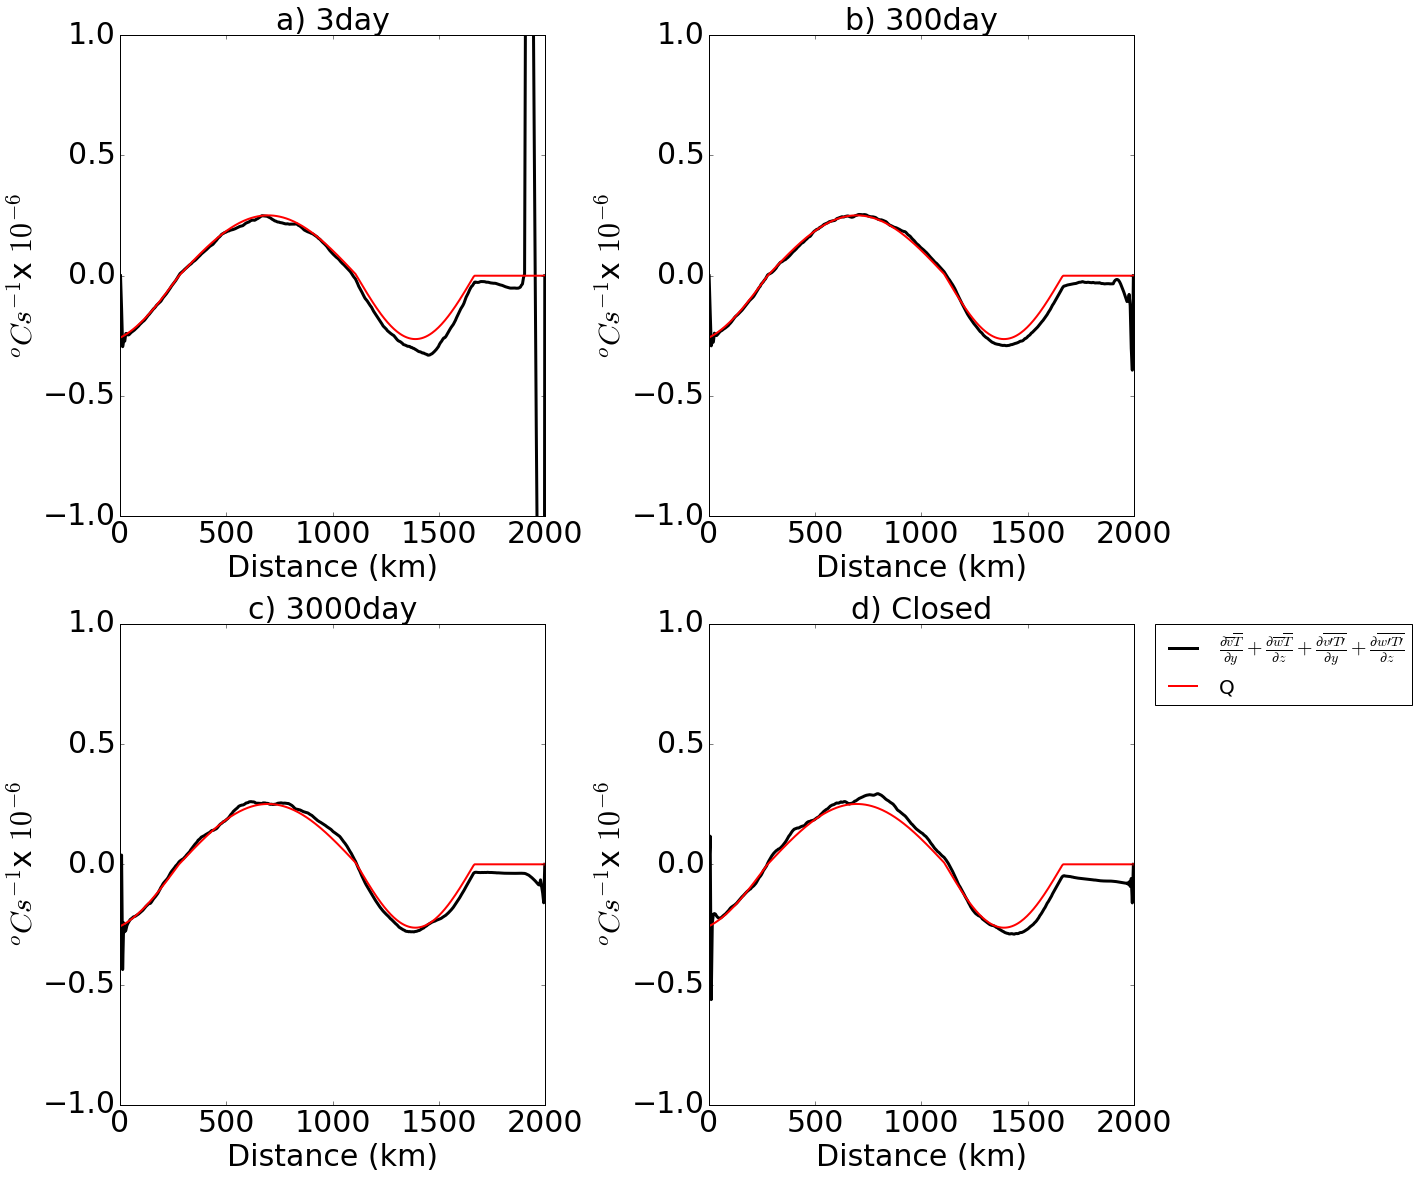

In [8]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*np.tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar                                                   
    # put everything on the C Grid                                                         

    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol#[0:-1,:,:]
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol#[0:-1,:,:]
    Adv = (dVTe.sum(axis=0) + dWTe.sum(axis=0) + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol)
    Diff = -(5000*Adv).mean(axis=1)
    Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
    Psipred = (Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000,(Diff+Surcor)*10**6,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(Psipred/c.dzf[0])*10**6,'r',linewidth=2)
    plt.ylim(-1,1)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'$\frac{\partial\overline{v}\overline{T}}{\partial y}+'+
                  r'\frac{\partial\overline{w}\overline{T}}{\partial z}+'+
                  r'\frac{\partial \overline{v\prime T\prime }}{\partial y}'+ 
                  r'+ \frac{\partial \overline{w\prime T\prime }}{\partial z} $'
                  ,'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:34: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:34: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:35: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:36: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:38: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:40: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:36: RuntimeWarning: invalid value encountered in subtract
/noc/users/hb1g13/anaco

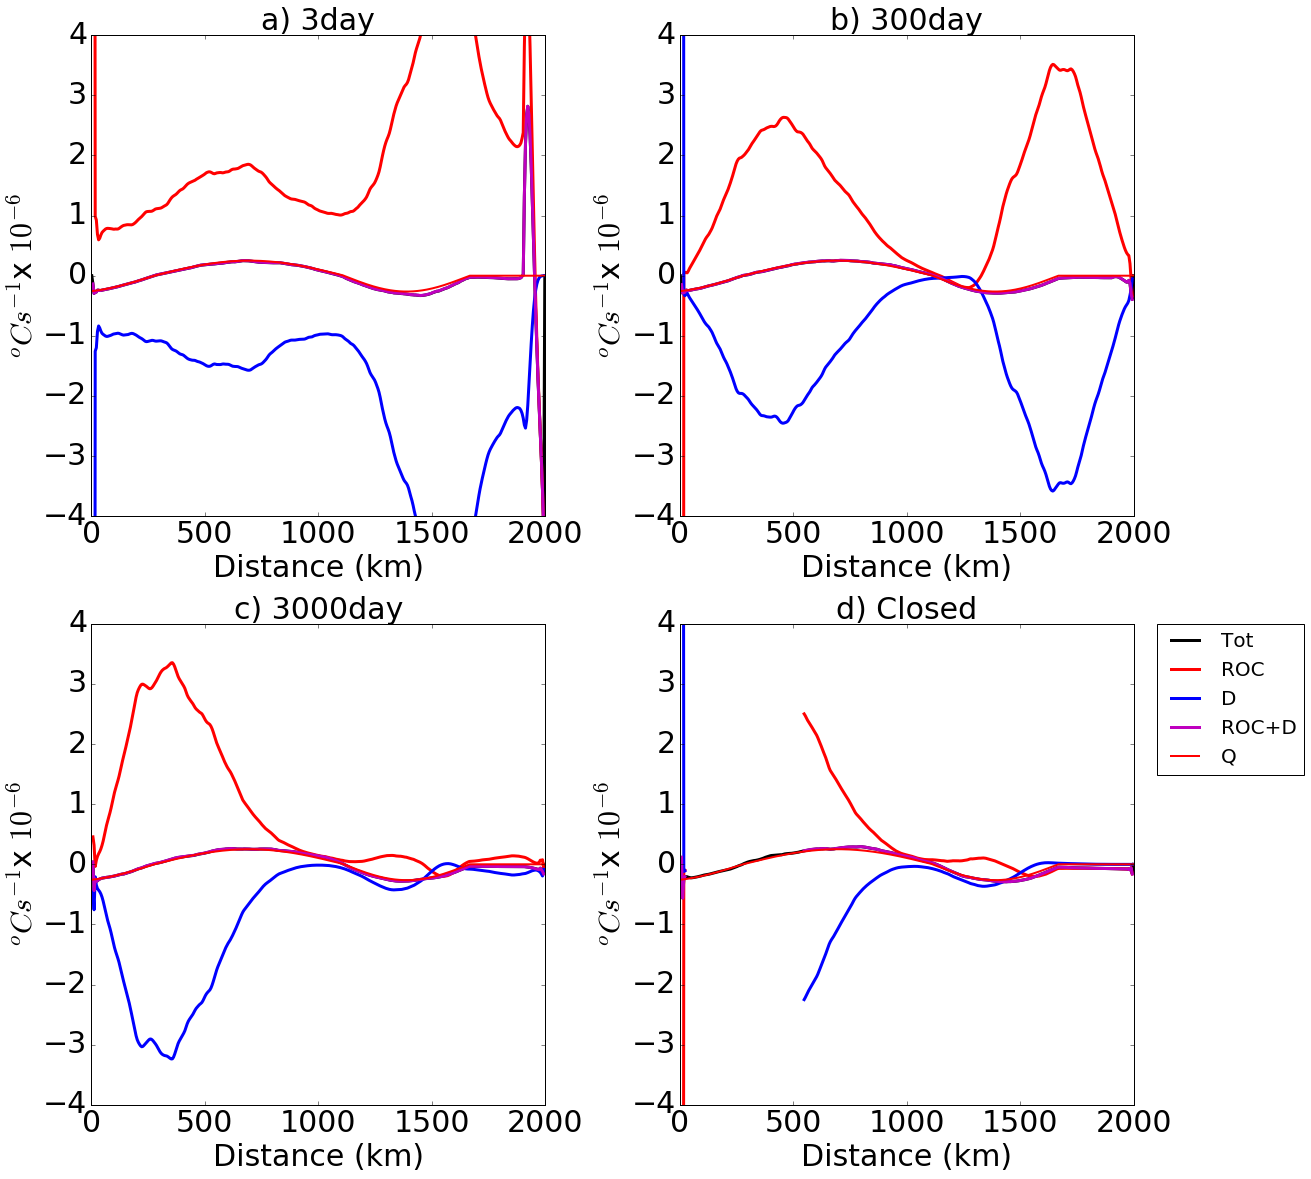

In [9]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac * np.tile(c.dzf, (c.Nx, c.Ny, 1)).T
    Nx, Ny, Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar
    # put everything on the C Grid
    VT = (c.mnc('Tav_VT.nc', 'VVELTH'))
    WT = (c.mnc('Tav_VT.nc', 'WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc', 'THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc', 'THETA'))
    V = (c.mnc('Tav.nc', 'VVEL'))
    W = (c.mnc('Tav.nc', 'WVEL'))
    npad = ((1, 0), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = V * Tv
    WTbar = W * Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:, 0:-1, :] - VTbar[:, 1::, :])*CellVol
    dWTbar = (WTbar[1::, :, :] - WTbar[0:-1, :, :])*CellVol
    dVTe = (VpTp[:, 0:-1, :] - VpTp[:, 1::, :])*CellVol
    dWTe = (WpTp[1::, :, :] - WpTp[0:-1, :, :])*CellVol
    Ty = (Tv[:, 0:-1, :] - Tv[:, 1::, :])*CellVol
    Tz = (Tw[1::, :, :] - Tw[0:-1, :, :])*CellVol
    Sp = np.zeros((c.Nz, c.Ny, c.Nx))
    Sp = -Ty/Tz
    Ade = ((c.vgrid_to_cgrid(VpTp)*Sp)[1::, :, :]
           - (c.vgrid_to_cgrid(VpTp)*Sp)[0:-1, :, :])*CellVol[0:-1, :, :]
    DE = ((c.wgrid_to_cgrid(WpTp)
           -(c.vgrid_to_cgrid(VpTp)*Sp))[1::, :, :]
          -(c.wgrid_to_cgrid(WpTp)
            -(c.vgrid_to_cgrid(VpTp)*Sp))[0:-1, :, :])*CellVol[0:-1, :, :]
    D = -5000*((DE.sum(axis=0))/sum(CellVol)).mean(axis=1)
    ROC = -5000*((Ade.sum(axis=0)
                  + dVTe.sum(axis=0) + dVTbar.sum(axis=0)
                  + dWTbar.sum(axis=0))/sum(CellVol)).mean(axis=1)
    Adv = (dVTe.sum(axis=0) + dWTe.sum(axis=0) + dVTbar.sum(axis=0) +
           dWTbar.sum(axis=0))/sum(CellVol)
    Diff = -(5000*Adv).mean(axis=1)
    Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
    Psipred = (Q)/(1000 * 3985)
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000, (Diff+Surcor)*10**6, 'k', linewidth=3)
    p = plt.plot(c.yc/1000, (ROC)*10**6, 'r', linewidth=3)
    p = plt.plot(c.yc/1000, (D)*10**6, 'b', linewidth=3)
    p = plt.plot(c.yc/1000, (ROC+D+Surcor)*10**6, 'm', linewidth=3)
    p = plt.plot(c.yc/1000, (Psipred/c.dzf[0])*10**6, 'r', linewidth=2)
    plt.ylim(-4, 4)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'Tot', 'ROC', 'D', 'ROC+D', 'Q',
                  'Q'], bbox_to_anchor=(1.05, 1), loc=2,
                 borderaxespad=0., fontsize=20)
plt.tight_layout()

#Residual mean full depth

\begin{equation}
J(\psi_{res},\overline{T})=\frac{\partial B}{\partial z}- \frac{\partial \left(\overline{w'T'}-S_p.\overline{v'T'}\right)}{\partial z },
\end{equation} 

\begin{equation}
J(\Psi_{res},\overline{T}) = \underbrace{\frac{\partial B}{\partial z}}_\text{Air-sea fluxes} - \underbrace{\frac{\partial \overline{w'T' - \Psi ^*. T_z.S_p  }}{\partial z }}_\text{Diabatic eddies} 
\end{equation} 

(Y,Z) space

In [ ]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    i=0
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    
    # Cartesian components w'T' Tz and Sp
    CellVol = c.rac * np.tile(c.dzf, (c.Nx, c.Ny, 1)).T
    WT = (c.mnc('Tav_VT.nc', 'WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc', 'THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc', 'THETA'))
    W = (c.mnc('Tav.nc', 'WVEL'))
    npad = ((1, 0), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    WTbar = W * Tw
    WpTp = WT - WTbar
    dWTe = (WpTp[1::, :, :] - WpTp[0:-1, :, :])*CellVol
    Ty = (Tv[:, 0:-1, :] - Tv[:, 1::, :])*CellVol
    Tz = (Tw[1::, :, :] - Tw[0:-1, :, :])*CellVol
    Sp = np.zeros((c.Nz, c.Ny, c.Nx))
    Sp = -Ty/Tz
    
    #Surface fluxes
    Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
    Psipred = (Q)/(1000 * 3985)
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    
    # ROC PyTz * PzTy
    g = layers_calc_numba.LayersComputer(c)
    psi = c.get_psi_iso()
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    psiz = g.transform_g_to_z(psi, th) 
    py_z = (psiz[:, 0:-1] - psiz[:, 1::])*CellVol[:,:,1]/CellVol[:,:,1].sum()
    npad = ((1, 0), (0, 0))
    psiz = np.pad(psiz, pad_width=npad, mode='constant', constant_values=0)
    pz_z = c.vgrid_to_cgrid(psiz[0:-1, :] - psiz[1::, :])*CellVol[:,:,1]/CellVol[:,:,1].sum()
    ROC = (pz_z*Ty.mean(axis=2) + py_z*Tz.mean(axis=2)).sum(axis=0)/CellVol.sum()
    
    # Diabatic Eddies d(w'T'-Psi*Ty)/dz
    lvrho , th = g.compute_vflux()
    V = lvrho.mean(axis=2)
    psi = -V.cumsum(axis=0)*c.Lx
    psied = c.vgrid_to_cgrid(c.get_psi_iso()) - psi
    psiedz = g.transform_g_to_z(psied,th.mean(axis=2))
    Ty = (Tv[:, 0:-1, :] - Tv[:, 1::, :])/5000
    psiedz = np.pad(psiedz, pad_width=npad, mode='constant', constant_values=0)
    DE = WpTp.mean(axis=2)+psiedz*utils.cgrid_to_wgrid(Ty.mean(axis=2))
    DEz = ((DE[1::, :] - DE[0:-1, :])*CellVol[:,:,1]).sum(axis=0)/CellVol.sum()
    ax = fig.add_subplot(2, 2, i+1)
    #p = plt.plot(c.yc/1000, (Diff+Surcor)*10**6, 'k', linewidth=3)
    p = plt.plot(c.yc/1000, ROC*10**6, 'r', linewidth=3)
    p = plt.plot(c.yc/1000, -(ROC-Psipred/c.dzf[0])*10**6, 'b', linewidth=3)
    p = plt.plot(c.yc/1000, (DEz)*10**6, 'm', linewidth=3)
    p = plt.plot(c.yc/1000, (Psipred/c.dzf[0])*10**6, 'k', linewidth=2)
    plt.ylim(-1, 1)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'ROC', 'D(imp)', 'D(ex)', 
                  'Q'], bbox_to_anchor=(1.05, 1), loc=2,
                 borderaxespad=0., fontsize=20)
plt.tight_layout()

(y,T) Space

\begin{equation}
\frac{\partial \overline{WT(y,T)}}{\partial T} + \frac{\partial \overline{VT(y,T)}}{\partial y} = \frac{\partial \overline{Q}}{\partial T}
\end{equation}

In [6]:
LVT.shape

(42, 400, 200)

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: RuntimeWarning: invalid value encounte

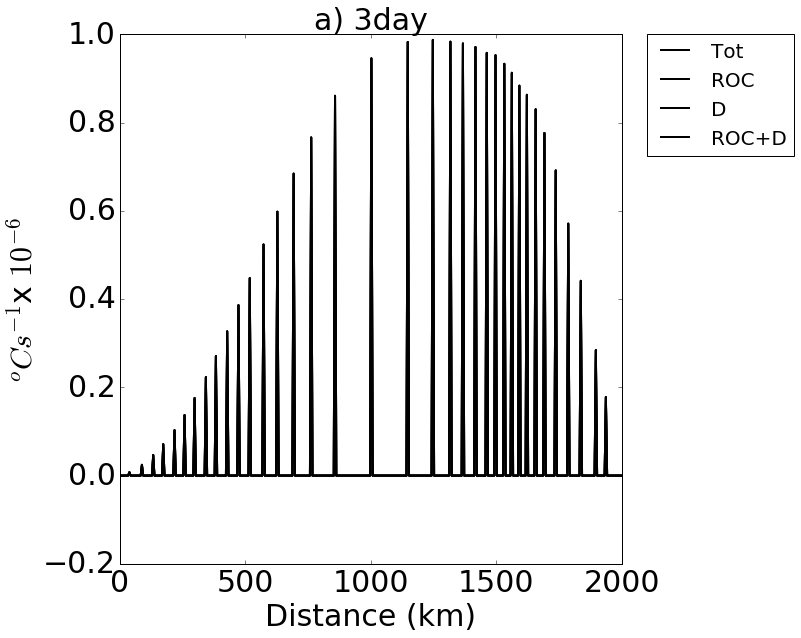

In [8]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    i = 0 
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    WT = (c.mnc('Tav_VT.nc', 'WVELTH'))
    VT = (c.mnc('Tav_VT.nc', 'VVELTH'))
    g = layers_calc_numba.LayersComputer(c)
    T = c.mnc('Tav.nc', 'THETA')
    V = (c.mnc('Tav.nc', 'VVEL'))
    W = (c.mnc('Tav.nc', 'WVEL'))
    # Extract Layer thicknes to in first interpolation
    LWT, th = g.interp_to_g(WT,T)
    LVT = g.interp_to_g(VT,T)[0]
    LW = g.interp_to_g(W,T)[0]
    LV = g.interp_to_g(V,T)[0]
    LT = g.interp_to_g(T,T)[0]
    Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
    Psipred = np.tile((Q)/(1000*3985),(c.Nz, 1))
    # 
    th = c.mnc('PSI.nc','LaHs1TH').mean(axis=2)
    dLVTy = utils.ddy_Lgrid_centered(LVT.mean(axis=2), c.dyg)
    dLWTz = utils.ddT_Lgrid_centered(LWT.mean(axis=2),c.vgrid_to_cgrid(th))
    ROC = (dLVTy+dLWTz).sum(axis=0)
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000, ROC , 'k', linewidth=2)
    #plt.ylim(-1, 1)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'Tot', 'ROC', 'D', 'ROC+D', 'Q',
                  'Q'], bbox_to_anchor=(1.05, 1), loc=2,
                 borderaxespad=0., fontsize=20)
plt.tight_layout()

In [16]:
D.shape

(29, 400, 200)

In [ ]:
fig = plt.figure(figsize=(18.5, 16.5))
for i in range(len(Runs)):

    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # Calculate cartesian diabatic eddies 
     # PLOT PANNELS
    CellVol = c.rac * np.tile(c.dzf, (c.Nx, c.Ny, 1)).T
    Nx, Ny, Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar
    # put everything on the C Grid
    VT = (c.mnc('Tav_VT.nc', 'VVELTH'))
    WT = (c.mnc('Tav_VT.nc', 'WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc', 'THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc', 'THETA'))
    V = (c.mnc('Tav.nc', 'VVEL'))
    W = (c.mnc('Tav.nc', 'WVEL'))
    npad = ((1, 0), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = V * Tv
    WTbar = W * Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:, 0:-1, :] - VTbar[:, 1::, :])*CellVol
    dWTbar = (WTbar[1::, :, :] - WTbar[0:-1, :, :])*CellVol
    dVTe = (VpTp[:, 0:-1, :] - VpTp[:, 1::, :])*CellVol
    dWTe = (WpTp[1::, :, :] - WpTp[0:-1, :, :])*CellVol
    Ty = (Tv[:, 0:-1, :] - Tv[:, 1::, :])*CellVol
    Tz = (Tw[1::, :, :] - Tw[0:-1, :, :])*CellVol
    Sp = np.zeros((c.Nz, c.Ny, c.Nx))
    Sp = -Ty/Tz
    Ade = ((c.vgrid_to_cgrid(VpTp)*Sp)[1::, :, :]
           - (c.vgrid_to_cgrid(VpTp)*Sp)[0:-1, :, :])*CellVol[0:-1, :, :]
    DE = ((c.wgrid_to_cgrid(WpTp)
           -(c.vgrid_to_cgrid(VpTp)*Sp))[1::, :, :]
          -(c.wgrid_to_cgrid(WpTp)
            -(c.vgrid_to_cgrid(VpTp)*Sp))[0:-1, :, :])*CellVol[0:-1, :, :]
    D = -5000*((DE/sum(CellVol)))
    D = np.pad(D, pad_width=npad, mode='constant', constant_values=0)
    DE_l , th_1 = g.interp_to_g(D,c.mnc('Tav.nc', 'THETA'))
    DE_l = DE_l.mean(axis=2)
    # Calculate diabatic layer depth and ROC 
    g = layers_calc_numba.LayersComputer(c)
    # ROC 
    psi = c.get_psi_iso()
    # Layer probability mask 
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI,PI<0.95)
    #psi = ma.masked_array(psi, PI < .98 )
    # Depths
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    depths = np.cumsum(th[::-1],axis=0)[::-1]
    Ty_l = g.interp_to_g(Ty,c.mnc('Tav.nc', 'THETA'))[0].mean(axis=2)
    # Find Max ROC and depth of diabatic layer
    DDL = np.zeros(len(c.yc)) 
    ROC = np.zeros(len(c.yc)) 
    Ty_dl = np.zeros(len(c.yc))
    DE_dl = np.zeros(len(c.yc)) 
    for jj in range(len(c.yc)):
        if ma.all(PI[:,jj]  == 1)  or np.all(psi[:,jj] == -0) or PI[:,jj].mask.all():
            continue
        indx = ma.nonzero(PI[:,jj]<1)[0]
        b = indx[np.nonzero(indx>3)[0]]
        if len(b)>=2 and (b[1]-b[0])>1:
            a = b[1]
        else:
            a = b[0]
        if a<41 and depths[a-1,jj] - depths[a,jj] > 150:
            a = a-1
        DDL[jj] = depths[a,jj]
        DE_dl[jj] = DE_l[a,jj]
        Ty_dl[jj] = Ty_l[a,jj]
        if psi[a,jj]/10**6 > 1.0:
            a = a-1
        ROC[jj] = psi[a,jj]
    
 
    Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
    Psipred = (Q)/(1000 * 3985)
    ax = fig.add_subplot(2, 2, i+1)
    #p = plt.plot(c.yc/1000, SG.savitzky_golay(ROC,41,1)*SG.savitzky_golay(Ty,41,1), 'k', linewidth=2)
    #q = plt.plot(c.yc/1000, (Psipred/c.dzc[0])*10**6, 'r', linewidth=3)
    #r = plt.plot(c.yc/1000, (SG.savitzky_golay(ROC,41,1)*SG.savitzky_golay(Ty,41,1)-(Psipred/c.dzc[0])*10**6), 'b', linewidth=1)
    q = plt.plot(c.yc/1000, SG.savitzky_golay(DDL,21,1)**10**5,'b',linewidth=3)
    #plt.ylim(-1.5,1.5)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel(r'$km$', fontsize=30)
    ax.set_ylabel(r'Depth', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)

plt.tight_layout()

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:36: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:36: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:37: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:38: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:40: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:42: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer w

In [20]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    
    # Cartesian components w'T' Tz and Sp
    CellVol = c.rac * np.tile(c.dzf, (c.Nx, c.Ny, 1)).T
    WT = (c.mnc('Tav_VT.nc', 'WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc', 'THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc', 'THETA'))
    W = (c.mnc('Tav.nc', 'WVEL'))
    npad = ((1, 0), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    WTbar = W * Tw
    WpTp = WT - WTbar
    dWTe = (WpTp[1::, :, :] - WpTp[0:-1, :, :])*CellVol
    Ty = (Tv[:, 0:-1, :] - Tv[:, 1::, :])*CellVol
    Tz = (Tw[1::, :, :] - Tw[0:-1, :, :])*CellVol
    Sp = np.zeros((c.Nz, c.Ny, c.Nx))
    Sp = -Ty/Tz
    
    #Surface fluxes
    Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
    Psipred = (Q)/(1000 * 3985)
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    
    # ROC PyTz * PzTy
    g = layers_calc_numba.LayersComputer(c)
    psi = c.get_psi_iso()
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    # In T space 
    # dPsi/dT
    dpT = utils.ddT_Lgrid_centered(psi,th)
    dpy = utils.ddy_Lgrid_centered(psi)
    ROC = (dpT+dpy)*g.glvls

    
    # Diabatic Eddies d(w'T'-Psi*Ty)/dz
    lvrho , th = g.compute_vflux()
    V = lvrho.mean(axis=2)
    psi = -V.cumsum(axis=0)*c.Lx
    psied = c.vgrid_to_cgrid(c.get_psi_iso()) - psi
    psiedz = g.transform_g_to_z(psied,th.mean(axis=2))
    psiedz = np.pad(psiedz, pad_width=npad, mode='constant', constant_values=0)
    DE = WpTp.mean(axis=2)-psiedz*utils.cgrid_to_wgrid(Ty.mean(axis=2))
    DEz = (DE[1::, :] - DE[0:-1, :]*CellVol[:,:,1]/CellVol[:,:,1].sum()).sum(axis=0)/CellVol.sum()
    ax = fig.add_subplot(2, 2, i+1)
    #p = plt.plot(c.yc/1000, (Diff+Surcor)*10**6, 'k', linewidth=3)
    p = plt.plot(c.yc/1000, ROC*10**6, 'r', linewidth=3)
    p = plt.plot(c.yc/1000, -(ROC-Psipred/c.dzf[0])*10**6, 'b', linewidth=3)
    p = plt.plot(c.yc/1000, (DEz)*10**6, 'm', linewidth=3)
    p = plt.plot(c.yc/1000, (Psipred/c.dzf[0])*10**6, 'k', linewidth=2)
    plt.ylim(-4, 4)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'Tot', 'ROC', 'D', 'ROC+D', 'Q',
                  'Q'], bbox_to_anchor=(1.05, 1), loc=2,
                 borderaxespad=0., fontsize=20)
plt.tight_layout()

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:21: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:21: RuntimeWarning: invalid value encountered in divide


TypeError: ddy_Lgrid_centered() takes exactly 2 arguments (1 given)

#Residual mean mixed layer depth

\begin{equation}
   \Psi_{res}  |_{hml}   =  \left( Q + \int_{-hml}^{0}\frac{\partial \left(w'T' - \overline{v'T'}.Sp  \right)}{\partial z} \mathrm{d}z \right) \left(  \frac{\partial \overline{b} }{\partial y }  \right)^{-1} 
\end{equation}

In [18]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    
    # Cartesian components w'T' Tz and Sp
    CellVol = c.rac * np.tile(c.dzf, (c.Nx, c.Ny, 1)).T
    WT = (c.mnc('Tav_VT.nc', 'WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc', 'THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc', 'THETA'))
    W = (c.mnc('Tav.nc', 'WVEL'))
    npad = ((1, 0), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    WTbar = W * Tw
    WpTp = WT - WTbar
    dWTe = (WpTp[1::, :, :] - WpTp[0:-1, :, :])*CellVol
    Ty = (Tv[:, 0:-1, :] - Tv[:, 1::, :])*CellVol
    Tz = (Tw[1::, :, :] - Tw[0:-1, :, :])*CellVol
    Sp = np.zeros((c.Nz, c.Ny, c.Nx))
    Sp = -Ty/Tz
    
    #Surface fluxes
    Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
    Psipred = (Q)/(1000 * 3985)
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    
    # ROC PyTz * PzTy
    g = layers_calc.LayersComputer(c)
    psi = c.get_psi_iso()
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    psiz = g.transform_g_to_z(psi, th) 
    py_z = (psiz[:, 0:-1] - psiz[:, 1::])*CellVol[:,:,1]/CellVol[:,:,1].sum()
    npad = ((1, 0), (0, 0))
    psiz = np.pad(psiz, pad_width=npad, mode='constant', constant_values=0)
    pz_z = c.vgrid_to_cgrid(psiz[0:-1, :] - psiz[1::, :])*CellVol[:,:,1]/CellVol[:,:,1].sum()
    ROC = (pz_z*Ty.mean(axis=2) + py_z*Tz.mean(axis=2)).sum(axis=0)/CellVol.sum()
    
    # Diabatic Eddies d(w'T'-Psi*Ty)/dz
    lvrho , th = g.compute_vflux()
    V = lvrho.mean(axis=2)
    psi = -V.cumsum(axis=0)*c.Lx
    psied = c.vgrid_to_cgrid(c.get_psi_iso()) - psi
    psiedz = g.transform_g_to_z(psied,th.mean(axis=2))
    psiedz = np.pad(psiedz, pad_width=npad, mode='constant', constant_values=0)
    DE = WpTp.mean(axis=2)-psiedz*utils.cgrid_to_wgrid(Ty.mean(axis=2))
    DEz = (DE[1::, :] - DE[0:-1, :]*CellVol[:,:,1]/CellVol[:,:,1].sum()).sum(axis=0)/CellVol.sum()
    ax = fig.add_subplot(2, 2, i+1)
    #p = plt.plot(c.yc/1000, (Diff+Surcor)*10**6, 'k', linewidth=3)
    p = plt.plot(c.yc/1000, ROC*10**6, 'r', linewidth=3)
    p = plt.plot(c.yc/1000, -(ROC-Psipred/c.dzf[0])*10**6, 'b', linewidth=3)
    p = plt.plot(c.yc/1000, (DEz)*10**6, 'm', linewidth=3)
    p = plt.plot(c.yc/1000, (Psipred/c.dzf[0])*10**6, 'k', linewidth=2)
    plt.ylim(-4, 4)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'Tot', 'ROC', 'D', 'ROC+D', 'Q',
                  'Q'], bbox_to_anchor=(1.05, 1), loc=2,
                 borderaxespad=0., fontsize=20)
plt.tight_layout()

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:21: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:21: RuntimeWarning: invalid value encountered in divide


NameError: name 'layers_calc' is not defined